<a href="https://colab.research.google.com/github/mvgarcia/GarciaValentina_RECV_Entrega8/blob/main/GarciaValentina_RECV_Entrega8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
#-- Descomprimimos el dataset
!rm -r /content/drive/MyDrive/ColabNotebooks/fashion-mnist
!unzip /content/drive/MyDrive/ColabNotebooks/fashion-mnist.zip

Streaming output truncated to the last 5000 lines.
  inflating: fashion-mnist/test/0/2423.png  
  inflating: fashion-mnist/test/0/444.png  
  inflating: fashion-mnist/test/0/965.png  
  inflating: fashion-mnist/test/0/1460.png  
  inflating: fashion-mnist/test/0/3440.png  
  inflating: fashion-mnist/test/0/2795.png  
  inflating: fashion-mnist/test/0/2474.png  
  inflating: fashion-mnist/test/0/169.png  
  inflating: fashion-mnist/test/0/1647.png  
  inflating: fashion-mnist/test/0/2121.png  
  inflating: fashion-mnist/test/0/2163.png  
  inflating: fashion-mnist/test/0/2753.png  
  inflating: fashion-mnist/test/0/645.png  
  inflating: fashion-mnist/test/0/34.png  
  inflating: fashion-mnist/test/0/716.png  
  inflating: fashion-mnist/test/0/3874.png  
  inflating: fashion-mnist/test/0/3128.png  
  inflating: fashion-mnist/test/0/2180.png  
  inflating: fashion-mnist/test/0/2439.png  
  inflating: fashion-mnist/test/0/269.png  
  inflating: fashion-mnist/test/0/2027.png  
  inflating:

In [27]:
#--- Buscamos las direcciones de cada archivo de imagen
from glob import glob

train_files = glob('./fashion-mnist/train/*/*.png')
valid_files = glob('./fashion-mnist/valid/*/*.png')
test_files = glob('./fashion-mnist/test/*/*.png')

#--- Ordenamos los datos de forma aleatoria para evitar sesgos
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

In [28]:
len(train_files)

55000

In [25]:
import torchvision.transforms as transforms

#--- Transformamos los datos para adaptarlos a la entrada de ResNet 224x224 px
data_transform = transforms.Compose([
                 transforms.Resize((224, 224)),
                 transforms.Grayscale(3), #Dado que MNIST tiene un solo canal, lo cambiamos a 3 para no tener que modificar más capas en el modelo
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                 ])

#Tomamos únicamente el 10% de los datos de entrenamiento y testeo para reescalarlos y tener valores parecidos a los del dataset trabajado en clase 

In [31]:
#--- Cargamos los datos de entrenamiento en listas
from PIL import Image

from tqdm.notebook import tqdm

N_train = len(train_files)

pbar = tqdm(total=int(N_train*0.1))
X_train = []
Y_train = []

for i, train_file in enumerate(train_files[:int(N_train*0.1)]):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append( np.array(data_transform(Image.open(train_file) )))
  pbar.update()
pbar.close()

#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

pbar = tqdm(total=int(N_test*0.1))
for i, test_file in enumerate(test_files[:int(N_test*0.1)]):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(data_transform(Image.open(test_file)) ))
  pbar.update()
pbar.close()

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


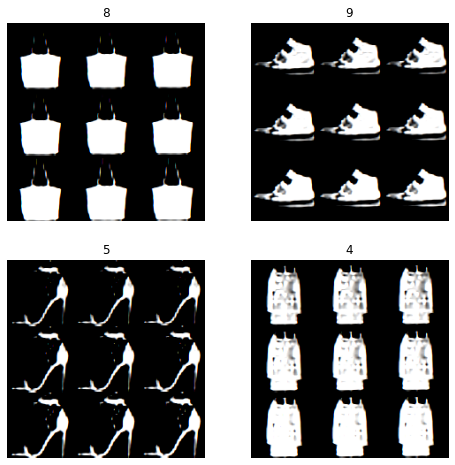

In [32]:
#-- Visualizamos los datos
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15].reshape(224,224,3))
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [33]:
#--- Convetimos las listas con los datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

print(X_train.data.size())

#-- Creamos el DataLoader

batch_size = 32

train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

torch.Size([5500, 3, 224, 224])


#Descripción de la CNN

Utilizamos el modelo ResNet de Redes residuales debido a que garantiza una normalización y estandarización de los datos en cada capa, lo que hace que el modelo converga a una solución adecuada más rápidamente

- Número de capas: 43
- Número de bloques: 4
- Número de capas convolucionales: 20
- Número de capas Max pooling y Average pooling: 1 y 1
- Batch Norm: 20
- Número de características de las capas convolucionales: 124, 40, 39, 38, 37, 22, 21, 12, 11, 6, 5, 4, 3, 2, 2

In [34]:
#--- Seleccionamos y cargamos el modelo
import torch

model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
model

Downloading: "https://github.com/pytorch/vision/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
#--- Congelamos los pesos en las capaz del modelo para que no se actualicen
for p in model.parameters():
    p.requires_grad = False

#--- Definimos el número de clases
out_dim = 10

#--- Reescribimos la nueva capa de salida con el nuevo dataset
model.fc = torch.nn.Sequential(
  torch.nn.Linear(model.fc.in_features, out_dim)
)


model.load_state_dict(model.state_dict())

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


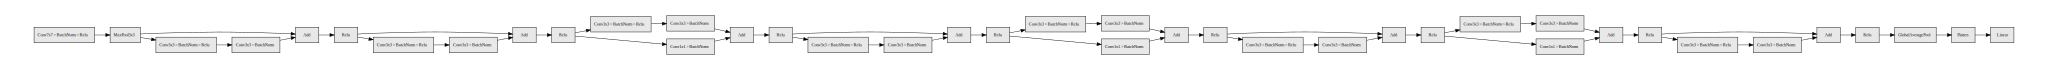

In [36]:
#!pip install hiddenlayer

#--- Visualizamos la estructura de nuestra CNN

import hiddenlayer as hl

hl.build_graph(model, torch.zeros([64,3,264,264]))

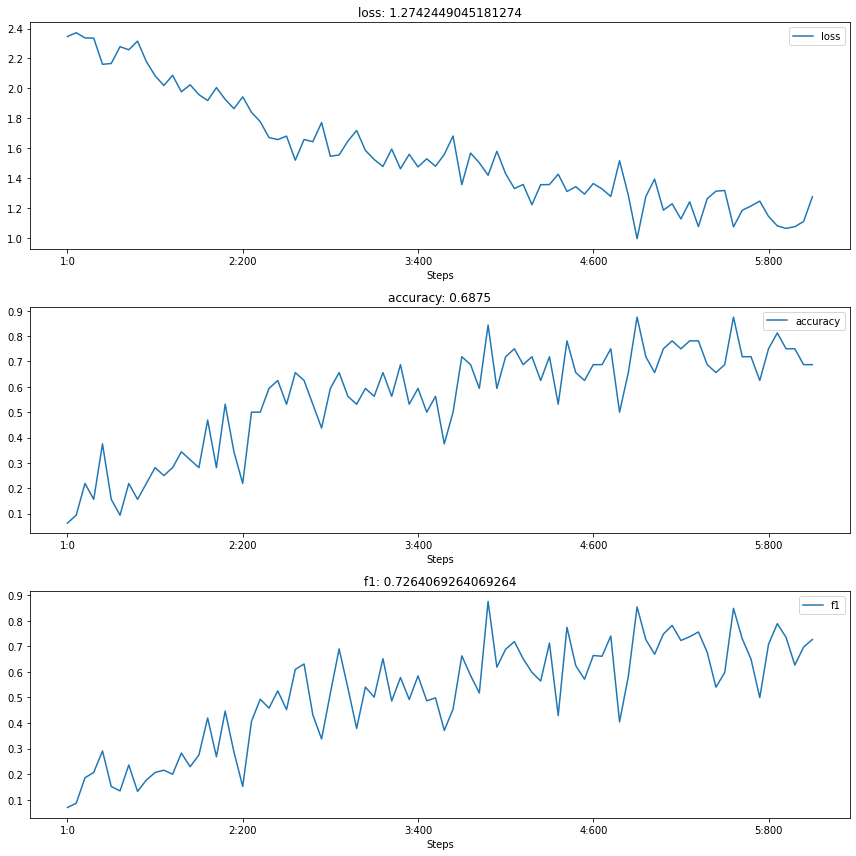

In [53]:
#--- Creamos variables para almacenar los scores en cada época 

from sklearn.metrics import f1_score

model.train()

#--- Definimos nuestro criterio de evaluación y el optimizador 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.1)
criterion = torch.nn.CrossEntropyLoss()


#--- Entrenamos el modelo usando únicamente 5 épocas
n_epochs = 5

history = hl.History()
canvas = hl.Canvas()

iter = 0

print(n_epochs*len(train_dl))
for epoch in range(n_epochs):
  for batch_idx, (X_train_batch, Y_train_batch) in enumerate(train_dl):
    # Pasamos os datos a 'cuda'
    
    X_train_batch = X_train_batch
    Y_train_batch = Y_train_batch

    # Realiza una predicción
    Y_pred = model(X_train_batch)

    # Calcula el loss
    loss = criterion(Y_pred, Y_train_batch)

    Y_pred = torch.argmax(Y_pred, 1)

    #Calcula el F1
    f1 = f1_score(Y_train_batch, Y_pred, average='macro')

    # Calcula el accuracy
    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iter%10 == 0:
        #-- Visualizamos la evolución de los score loss y accuracy
        history.log((epoch+1, iter), loss=loss, accuracy=acc, f1=f1)
        with canvas:
          canvas.draw_plot(history["loss"])
          canvas.draw_plot(history["accuracy"])
          canvas.draw_plot(history["f1"])

    iter += 1
    del X_train_batch, Y_train_batch, Y_pred


In [54]:
del train_dl

#-- Validamos el modelo
from sklearn.metrics import f1_score

model.cpu()
model.eval()

Y_pred = model(X_test)
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

Loss:1.11, F1:0.73, Acc:0.73


In [55]:
#--- Guardamos el nuevo Modelo
torch.save(model,open('./ResNet_fashion-MNIST.pt','wb'))

In [48]:
#-- Cogemos la última capa convolucional
list(list(model.children())[7][1].children())[3]

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [57]:
kernels = list(list(model.children())[7][1].children())[3].weight.detach()
kernels.size(0)

512

512


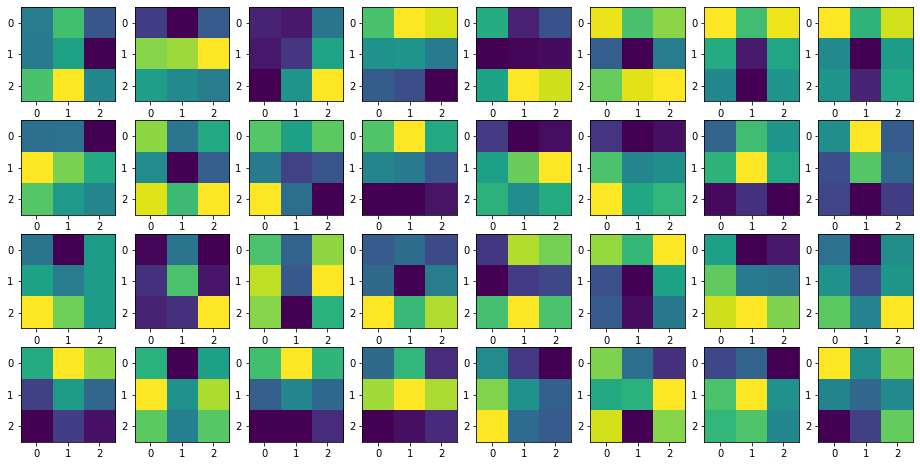

In [58]:
#-- Visualizando los mapas de características de la última capa convolucional
kernels = list(list(model.children())[7][1].children())[3].weight.detach()

fig = plt.figure(figsize=(16,8))
k = 0
print(kernels.size(0))

#Graficamos solo los 32 primeros mapas
for i in range(32):
    plt.subplot(4,8,k+1)
    plt.imshow(kernels[0][i].cpu().squeeze())
    k += 1
plt.show()

In [59]:
from sklearn.metrics import confusion_matrix

def CM(Y_true, Y_pred, classes, lclasses=None):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  if lclasses == None:
    lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()

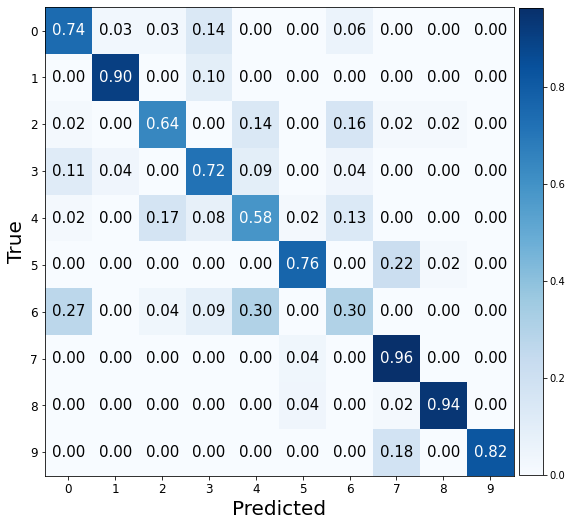

In [60]:
CM(Y_test, Y_pred, 10)

# Resultados obtenidos

- Loss:1.11
- F1:0.73 
- Accuracy:0.73

El modelo no es tan bueno debido a que tiene un Loss demasiado alto. Tiene un F1 y accuracy decentes, por lo que parece que tiene éxito realizando predicciones en la mayoría de los casos.

En cuanto a la matriz de confusión del bloque anterior, se ve que el objeto que mejor se predice es "7: Sneaker" y el peor es "6: Shirt". La confusión más grande se presenta nuevamente en "6: Shirt" cuando la identifica en igual proporción como "4: Coat".

Puede que al modelo le hayan faltado datos con los cuales entrenarse, dado que reducimos el dataset a solo el 10% de la cantidad original.
